In [1]:
!pip3 install tensorflow==2.0.0-beta0

     |████████████████████████████████| 87.9MB 133kB/s 
     |████████████████████████████████| 3.1MB 42.9MB/s 
     |████████████████████████████████| 501kB 64.0MB/s 
  Found existing installation: tensorflow 1.15.0
    Uninstalling tensorflow-1.15.0:
      Successfully uninstalled tensorflow-1.15.0


In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

print ("check tensorflow version: ", tf.__version__)
print ("check numpy version: ", np.__version__)

check tensorflow version:  2.0.0-beta0
check numpy version:  1.17.4


In [0]:
def plot_series(time, series, format="--", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time", fontsize=12)
    plt.ylabel("Value", fontsize=12)
    plt.grid(True)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.5,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

time = np.arange(4 * 365 + 1, dtype="float32")
series = trend(time, 0.1)  
baseline = 10
amplitude = 40
slope = 0.05
noise_level = 5

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# Update with noise
series += noise(time, noise_level, seed=42)

split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

#### Window Dataset:    
Previous _n_ values of a dataset will be used as input and the next value is treated as output. <br>

Use [TensorFlow Data-Sets](https://www.tensorflow.org/datasets) for the preparing features and labels.  

In [0]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

#### Helper Code-Block to Understand the Previous Function

In [7]:
a = tf.data.Dataset.range(12)
a = a.window(3, shift=2, drop_remainder=True)
a = a.flat_map(lambda x: x.batch(3))

print ("windowed and batch size if 3: \n")
for ele in a:
  print (ele.numpy())



##### Shuffle and separate features and labels 

a_ds = a.shuffle(2).map(lambda x: (x[:-1], x[-1]))

print ("shuffled and separated in features and labels: \n")

for ele_ds in a_ds:
  print (ele_ds)


a_ds = a_ds.batch(3).prefetch(2)

print ("Creating 3 batches of features and labels: \n")
for f in a_ds:
  print(f)


windowed and batch size if 3: 

[0 1 2]
[2 3 4]
[4 5 6]
[6 7 8]
[ 8  9 10]
shuffled and separated in features and labels: 

(<tf.Tensor: id=56, shape=(2,), dtype=int64, numpy=array([2, 3])>, <tf.Tensor: id=57, shape=(), dtype=int64, numpy=4>)
(<tf.Tensor: id=60, shape=(2,), dtype=int64, numpy=array([4, 5])>, <tf.Tensor: id=61, shape=(), dtype=int64, numpy=6>)
(<tf.Tensor: id=64, shape=(2,), dtype=int64, numpy=array([6, 7])>, <tf.Tensor: id=65, shape=(), dtype=int64, numpy=8>)
(<tf.Tensor: id=68, shape=(2,), dtype=int64, numpy=array([8, 9])>, <tf.Tensor: id=69, shape=(), dtype=int64, numpy=10>)
(<tf.Tensor: id=72, shape=(2,), dtype=int64, numpy=array([0, 1])>, <tf.Tensor: id=73, shape=(), dtype=int64, numpy=2>)
Creating 3 batches of features and labels: 

(<tf.Tensor: id=87, shape=(3, 2), dtype=int64, numpy=
array([[2, 3],
       [4, 5],
       [6, 7]])>, <tf.Tensor: id=88, shape=(3,), dtype=int64, numpy=array([4, 6, 8])>)
(<tf.Tensor: id=91, shape=(2, 2), dtype=int64, numpy=
array([[8,

In [0]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

In [0]:
#### Create the Data-Set

dataset = windowed_dataset(x_train, window_size, batch_size=128, shuffle_buffer=shuffle_buffer_size)  

#### Create the Neural Net with Simple RNN 
As described in the documentation of [Keras RNN layers](https://keras.io/layers/recurrent/), the shape of the input tensor is _(batch_size, timesteps, input_dim)_. So, it is a 3 dimensional tensor. But lookng back the helper code block, we see that the  tensor is 2 dimensional. 

So we need to use [_tf.expand_dims_](https://www.tensorflow.org/api_docs/python/tf/expand_dims). 

Here rather than changing the shape of the tensor outside of the Keras Model, we will use Keras [Lambda Layers](https://keras.io/layers/core/).  <br>

We will use another lambda layer to scale up the output of the time series. As the default activation function of the RNN layer is _tanh_, this outputs values between -1, 1. Since the time series output values are around 40, 50, 60, we scale up the output of the RNN layer to the same ballpark will help us learning.  

In [10]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]), # input shape is set to none, which means model can take sequence of any length. 
  tf.keras.layers.SimpleRNN(40, return_sequences=True),
  tf.keras.layers.SimpleRNN(40),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 95) 
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda (Lambda)              (None, None, 1)           0         
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, None, 40)          1680      
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 40)                3240      
_________________________________________________________________
dense (Dense)                (None, 1)                 41        
_________________________________________________________________
lambda_1 (Lambda)            (None, 1)                 0         
Total params: 4,961
Trainable params: 4,961
Non-trainable params: 0
_________________________________________________________________


#### Use Callback to Determine the Best Learning Rate

In [31]:
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.89)
model.compile(loss = tf.keras.losses.Huber(), 
              optimizer = optimizer, 
              metrics = ["mae"],)


lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-8 * (10**(epoch / 20 )))
history1 = model.fit(dataset, epochs=100, callbacks=[lr_schedule])


Epoch 1/100
31/31 [==============================] - 2s 52ms/step - loss: 48.2547 - mae: 48.7896
Epoch 2/100
31/31 [==============================] - 0s 11ms/step - loss: 45.7610 - mae: 46.2993
Epoch 3/100
31/31 [==============================] - 0s 11ms/step - loss: 42.8708 - mae: 43.4121
Epoch 4/100
31/31 [==============================] - 0s 11ms/step - loss: 39.7327 - mae: 40.2771
Epoch 5/100
31/31 [==============================] - 0s 11ms/step - loss: 36.3303 - mae: 36.8781
Epoch 6/100
31/31 [==============================] - 0s 11ms/step - loss: 32.6865 - mae: 33.2346
Epoch 7/100
31/31 [==============================] - 0s 11ms/step - loss: 28.8754 - mae: 29.4224
Epoch 8/100
31/31 [==============================] - 0s 11ms/step - loss: 24.9931 - mae: 25.5372
Epoch 9/100
31/31 [==============================] - 0s 11ms/step - loss: 21.8682 - mae: 22.4058
Epoch 10/100
31/31 [==============================] - 0s 10ms/step - loss: 19.8436 - mae: 20.3734
Epoch 11/100
31/31 [=========

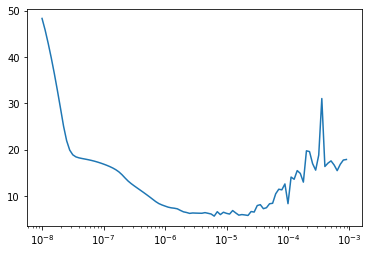

In [32]:
# plt.yscale('log')
plt.semilogx(history1.history["lr"], history1.history["loss"])
plt.show()

In [11]:
optimizer = tf.keras.optimizers.SGD(lr=6e-5, momentum=0.89)
model.compile(loss = tf.keras.losses.Huber(), 
              optimizer = optimizer, 
              metrics = ["mae"],)  


history = model.fit(dataset, epochs=400)

Epoch 1/400
8/8 [==============================] - 1s 166ms/step - loss: 61.2627 - mae: 63.3025
Epoch 2/400
8/8 [==============================] - 0s 23ms/step - loss: 15.3488 - mae: 16.1017
Epoch 3/400
8/8 [==============================] - 0s 20ms/step - loss: 13.7223 - mae: 14.4101
Epoch 4/400
8/8 [==============================] - 0s 22ms/step - loss: 13.0702 - mae: 13.6481
Epoch 5/400
8/8 [==============================] - 0s 21ms/step - loss: 10.7748 - mae: 11.1307
Epoch 6/400
8/8 [==============================] - 0s 19ms/step - loss: 8.0871 - mae: 8.5837
Epoch 7/400
8/8 [==============================] - 0s 21ms/step - loss: 12.4667 - mae: 12.6190
Epoch 8/400
8/8 [==============================] - 0s 22ms/step - loss: 12.8722 - mae: 13.3193
Epoch 9/400
8/8 [==============================] - 0s 21ms/step - loss: 12.8940 - mae: 13.2113
Epoch 10/400
8/8 [==============================] - 0s 23ms/step - loss: 11.6759 - mae: 12.3581
Epoch 11/400
8/8 [==============================] 

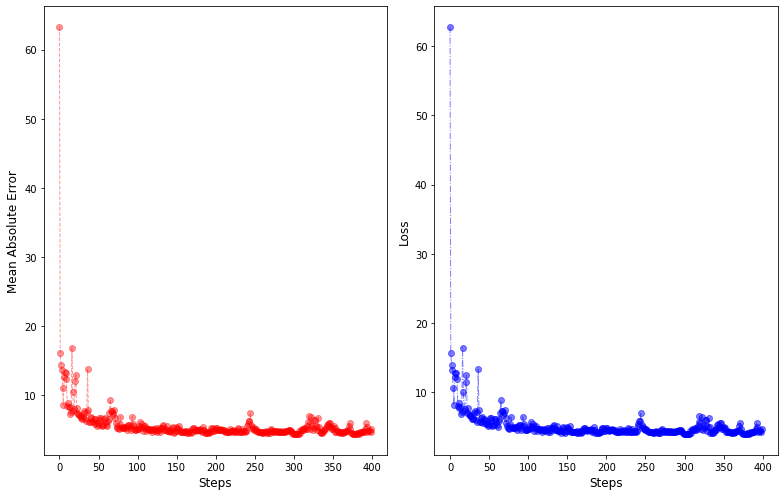

In [12]:
mae = history.history["mae"]
loss = history.history["loss"]

epochs = range(len(mae))

fig = plt.figure(figsize=(11, 7))
plt.subplot(1, 2, 1)
plt.xlabel("Steps", fontsize=12)
plt.ylabel("Mean Absolute Error", fontsize=12)
plt.plot(epochs, mae, linestyle='--', linewidth=1, marker='o', color='red', alpha=0.4)
# plt.xscale('log')
# plt.yscale('log')
plt.subplot(1, 2, 2)
plt.xlabel("Steps", fontsize=12)
plt.ylabel("Loss", fontsize=12)
plt.plot(epochs, loss, linestyle='-.', linewidth=1, marker='o', color='blue', alpha=0.5)
plt.tight_layout()
plt.show()

#### Comparison and Prediction 

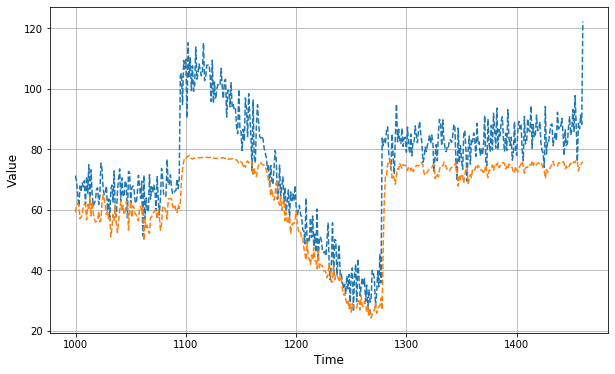

In [13]:
forecast=[]
for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [14]:
#### Error MAE
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

10.914217